# Suavizamiento Exponencial Simple (SES) con notación matricial
Notebook didáctico. Solo NumPy y matplotlib. Se muestran PNG y se formaliza el filtro en álgebra lineal.


## 1) Desagregación de la serie
Supondremos que la observación se descompone como

$$ y_t = s_t + \varepsilon_t, \quad t=0,1,\dots,n-1, $$
donde $s_t$ es el **nivel** (tendencia local) y $\varepsilon_t$ es el residuo de uno a paso.


## 2) Modelo SES y expansión cerrada
Recursión de nivel:

$$ L_0 = y_0, \qquad L_t = \alpha y_t + (1-\alpha) L_{t-1},\quad 0<\alpha\le 1. $$
Fitted one-step: $\hat y_t=L_{t-1}$ para $t\ge 1$. Expansión explícita por sustitución:
$$ L_t = (1-\alpha)^t y_0 + \alpha\sum_{j=1}^{t} (1-\alpha)^{t-j} y_j. $$
Esto muestra que SES es un **promedio móvil exponencial** con pesos decrecientes geométricamente.


## 3) Notación matricial del filtro exponencial
Sea $Y=[y_1,\dots,y_n]'$ y $S=[L_1,\dots,L_n]'$. Existe una matriz estrictamente triangular inferior $W(\alpha)\in\mathbb{R}^{n\times n}$ tal que $S=W(\alpha)\,Y$, con
$$ W_{t,t'}(\alpha)= \begin{cases}
(1-\alpha)^{t-1}, & t'=1, \\
\alpha(1-\alpha)^{t-t'}, & 2\le t'\le t, \\
0, & t'<t.
\end{cases} $$
Ejemplo de estructura ($n=6$):
$$
W(\alpha)=\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
(1-\alpha) & \alpha & 0 & 0 & 0 & 0\\
(1-\alpha)^2 & \alpha(1-\alpha) & \alpha & 0 & 0 & 0\\
(1-\alpha)^3 & \alpha(1-\alpha)^2 & \alpha(1-\alpha) & \alpha & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & 0\\
(1-\alpha)^5 & \alpha(1-\alpha)^4 & \alpha(1-\alpha)^3 & \alpha(1-\alpha)^2 & \alpha(1-\alpha) & \alpha
\end{bmatrix}.$$
Así, el filtro SES es lineal y **causal**: $L_t$ depende solo de $\{y_j\}_{j\le t}$.


## 4) Elección de $\alpha$ y vida media efectiva
Elegimos $\alpha$ minimizando el MSE in-sample de los one-step errors $e_t=y_t-\hat y_t$ con $t\ge1$:
$$ \operatorname{MSE}(\alpha)=\frac{1}{n-1}\sum_{t=1}^{n-1} e_t(\alpha)^2. $$
La **vida media** de los pesos exponenciales satisface $(1-\alpha)^{h_{1/2}}=\tfrac12$, por lo que
$$ h_{1/2} = \frac{\ln(1/2)}{\ln(1-\alpha)}. $$
Pequeño $\alpha$ $\Rightarrow$ larga memoria; grande $\alpha$ $\Rightarrow$ reacción rápida.


## 5) Carga de datos y ajuste
Intentamos leer `cd/../data/air_passengers.csv` con cabeceras `Month,#Passengers`. Si no existe, usamos una muestra corta.


In [ ]:
import csv, numpy as np

csv_path = 'cd/../data/air_passengers.csv'
fallback = [
    ('1949-01',112),('1949-02',118),('1949-03',132),('1949-04',129),
    ('1949-05',121),('1949-06',135),('1949-07',148),('1949-08',148),('1949-09',136)
]

def try_load_csv(path):
    try:
        with open(path,'r',encoding='utf-8',newline='') as f:
            r = csv.DictReader(f)
            months, values = [], []
            for row in r:
                mk = next((k for k in row if k.lower().strip()=='month'), None)
                yk = next((k for k in row if k.lower().strip() in ('#passengers','passengers')), None)
                if mk is None or yk is None:
                    continue
                months.append(row[mk].strip())
                values.append(float(row[yk]))
            if values:
                return months, np.array(values, float)
    except Exception:
        pass
    return [m for m,_ in fallback], np.array([v for _,v in fallback], float)

months, y = try_load_csv(csv_path)
n = len(y); t = np.arange(n)
print(f'Loaded n={n} observations.')

## 6) Implementación del SES y selección de $\alpha$
Aplicamos la recursión y hacemos una búsqueda en malla para $\alpha\in(0,1]\.$


In [ ]:
import numpy as np

def ses_fit(y, alpha):
    y = np.asarray(y, float)
    n = y.size
    if not (0 < alpha <= 1):
        raise ValueError('alpha in (0,1]')
    L = np.empty(n, float)
    yhat = np.empty(n, float)
    L[0] = y[0]
    yhat[0] = y[0]
    for t in range(1, n):
        L[t]   = alpha * y[t] + (1 - alpha) * L[t-1]
        yhat[t]= L[t-1]
    err = y - yhat
    return L, yhat, err

def mse_mae(err, skip_first=True):
    s = 1 if skip_first else 0
    e = err[s:]
    return float(np.mean(e*e)), float(np.mean(np.abs(e)))

def grid_search_alpha(y, alphas=None):
    if alphas is None:
        alphas = np.linspace(0.01, 0.99, 99)
    best = None
    for a in alphas:
        L, yhat, err = ses_fit(y, a)
        mse, mae = mse_mae(err, skip_first=True)
        if (best is None) or (mse < best['mse']):
            best = {'alpha': float(a), 'mse': mse, 'mae': mae, 'L': L, 'yhat': yhat, 'err': err}
    return best

best = grid_search_alpha(y)
alpha_star = best['alpha']
L, yhat, err = best['L'], best['yhat'], best['err']
mse, mae = best['mse'], best['mae']
print(f'alpha*={alpha_star:.3f}, MSE={mse:.3f}, MAE={mae:.3f}')

## 7) Pronósticos
Para SES, el pronóstico $h$-pasos adelante después del último punto es constante:
$$ \hat y_{n+h\,|\,n-1} = L_{n-1}, \quad h\ge 1. $$


In [ ]:
def ses_forecast_last_level(L, h):
    if L.size == 0:
        return np.array([])
    return np.full(h, L[-1], float)

h = 6
y_fcst = ses_forecast_last_level(L, h)
print('Next 6 forecasts:', y_fcst)

## 8) Visualización (PNG con matplotlib)
La curva discontinua es el ajuste de un paso $\hat y_t=L_{t-1}$.

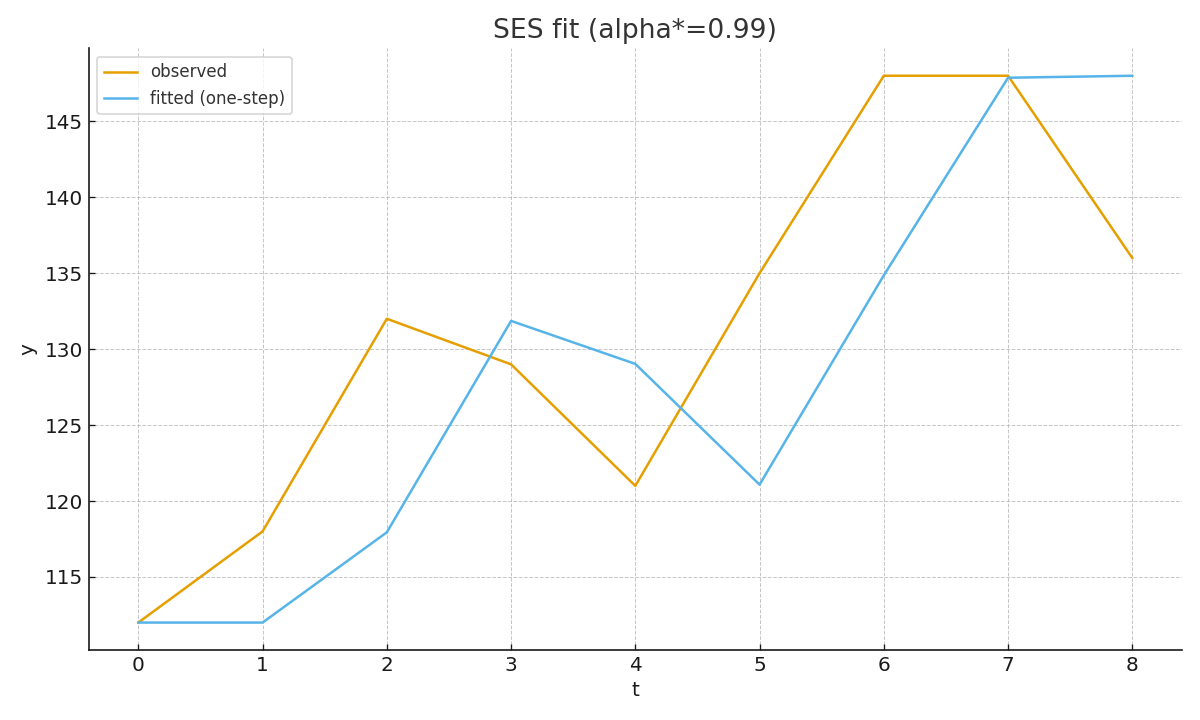

In [1]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(t, y, label='observed')
plt.plot(t, yhat, label='fitted (one-step)')
plt.xlabel('t'); plt.ylabel('y'); plt.title(f'SES fit (alpha*={alpha_star:.2f})')
plt.legend(); plt.tight_layout(); plt.show()

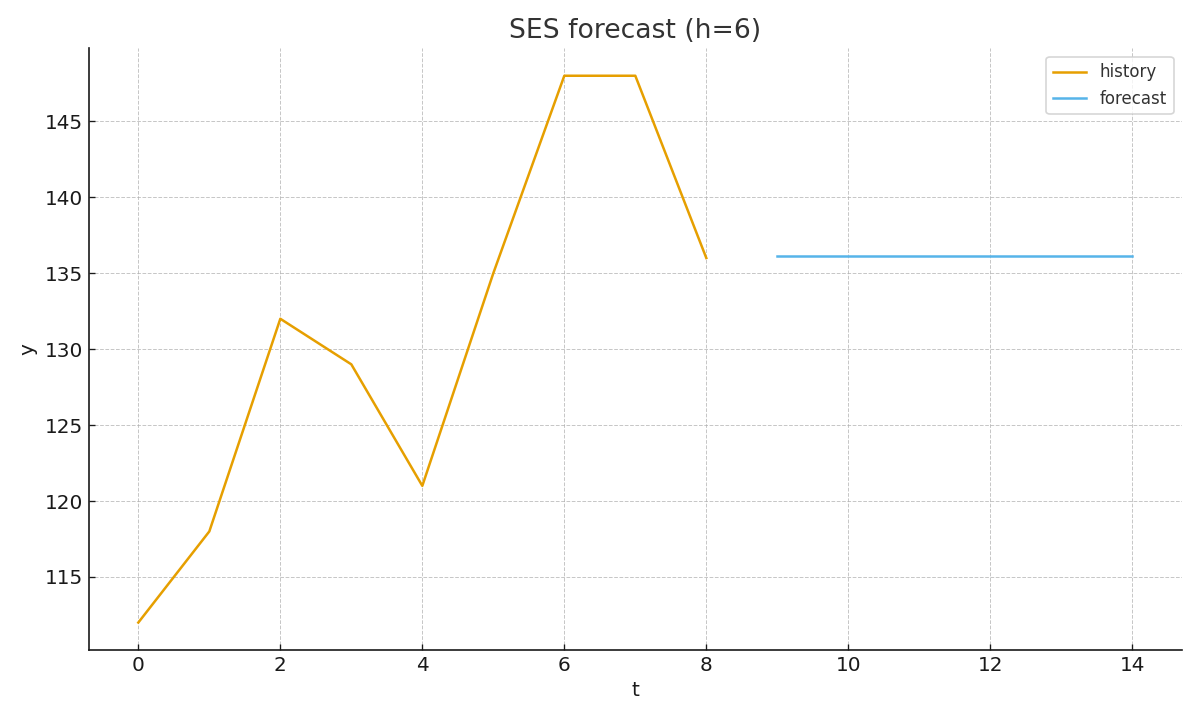

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(t, y, label='history')
plt.plot(np.arange(n, n+6), y_fcst, label='forecast')
plt.xlabel('t'); plt.ylabel('y'); plt.title('SES forecast (h=6)')
plt.legend(); plt.tight_layout(); plt.show()

## 9) Construcción explícita de $W(\alpha)$ y ejemplo pequeño
Para $T=5$ y $\alpha=0.4$, la relación $S=WY$ produce las siguientes combinaciones lineales:
$$\begin{aligned}
 s_1 &= & &1.00y_1\\
 s_2 &= & &0.60y_1 &+&0.40y_2\\
 s_3 &= & &0.36y_1 &+&0.24y_2 &+&0.40y_3\\
 s_4 &= & &0.22y_1 &+&0.14y_2 &+&0.24y_3 &+&0.40y_4\\
 s_5 &= & &0.13y_1 &+&0.09y_2 &+&0.14y_3 &+&0.24y_4 &+&0.40y_5\end{aligned}$$
Observe la naturaleza de **promedio ponderado** y que los pesos decrecen geométricamente sobre el pasado.


In [ ]:
import numpy as np

def ewma_weight_matrix(alpha, n):
    a = float(alpha)
    W = np.zeros((n, n), float)
    for t in range(n):
        for j in range(t+1):
            if j == 0:
                W[t, 0] = (1 - a)**t
            else:
                W[t, j] = a * (1 - a)**(t - j)
    return W

W = ewma_weight_matrix(alpha_star, n)
print('W shape:', W.shape)
print('First 3 rows of W (rounded):\n', np.round(W[:3,:6], 3))

## 10) Apéndice: contraste con el filtro de Hodrick–Prescott
HP busca $S$ como la solución de
$$ \min_S\ \|Y-S\|^2 + \lambda\,\|AS\|^2, $$
con $A$ la matriz de segundas diferencias (dimensión $(T-2)\times T$). Las CPO implican
$$ S^{HP} = (I + \lambda A' A)^{-1} Y, \qquad C^{HP}=Y-S^{HP}. $$
**Diferencia clave:** SES es un filtro recursivo causal con parámetro $\alpha$; HP es un estimador global que resuelve un sistema lineal con parámetro de suavidad $\lambda$.


### Notas finales
- Inicialización usada: $L_0=y_0$. Otras opciones existen.
- La malla de $\alpha$ puede refinarse o sustituirse por optimización continua.
- SES no modela tendencia ni estacionalidad explícitas; para ello use Holt o Holt–Winters.